In [1]:
# Quick diagnostic: test WMT19 dataset loading
from datasets import load_dataset
import os
from dotenv import load_dotenv

load_dotenv()

print("Testing WMT19 dataset loading...")

# Try loading with different approaches to see what works
try:
    print("Attempt 1: wmt/wmt19 with zh-en config...")
    ds = load_dataset('wmt/wmt19', 'zh-en', split='test')
    print(f"✓ Success! Dataset has {len(ds)} examples")
    
    # Test first example structure
    example = ds[0]
    print(f"Example structure: {list(example.keys())}")
    print(f"Translation structure: {example['translation']}")
    
except Exception as e:
    print(f"✗ Failed: {e}")
    
    try:
        print("\nAttempt 2: wmt19_translate/zh-en...")
        ds = load_dataset('wmt19_translate', 'zh-en', split='test')
        print(f"✓ Success! Dataset has {len(ds)} examples")
    except Exception as e2:
        print(f"✗ Also failed: {e2}")
        
        try:
            print("\nAttempt 3: List available configs...")
            from datasets import get_dataset_config_names
            configs = get_dataset_config_names('wmt/wmt19')
            print(f"Available configs: {configs}")
        except Exception as e3:
            print(f"✗ Config listing failed: {e3}")

/home/silvi/notebooks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing WMT19 dataset loading...
Attempt 1: wmt/wmt19 with zh-en config...
✗ Failed: Unknown split "test". Should be one of ['train', 'validation'].

Attempt 2: wmt19_translate/zh-en...
✗ Failed: Unknown split "test". Should be one of ['train', 'validation'].

Attempt 2: wmt19_translate/zh-en...
✗ Also failed: Dataset 'wmt19_translate' doesn't exist on the Hub or cannot be accessed.

Attempt 3: List available configs...
✗ Also failed: Dataset 'wmt19_translate' doesn't exist on the Hub or cannot be accessed.

Attempt 3: List available configs...
Available configs: ['cs-en', 'de-en', 'fi-en', 'fr-de', 'gu-en', 'kk-en', 'lt-en', 'ru-en', 'zh-en']
Available configs: ['cs-en', 'de-en', 'fi-en', 'fr-de', 'gu-en', 'kk-en', 'lt-en', 'ru-en', 'zh-en']


In [2]:
# Test accelerate import and alternative model loading approach
try:
    import accelerate
    print(f"✓ Accelerate version: {accelerate.__version__}")
    
    # Test if accelerate is properly detected by transformers
    from transformers import is_accelerate_available
    print(f"✓ Transformers detects accelerate: {is_accelerate_available()}")
    
except ImportError as e:
    print(f"✗ Accelerate import failed: {e}")

# Alternative model loading without device_map for compatibility
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

✓ Accelerate version: 1.11.0
✗ Accelerate import failed: cannot import name 'is_accelerate_available' from 'transformers' (/home/silvi/notebooks/.venv/lib/python3.13/site-packages/transformers/__init__.py)
PyTorch version: 2.9.0+rocm6.4
CUDA available: True
CUDA device count: 1
Current device: 0
Device name: AMD Radeon RX 7900 GRE


In [3]:
# Modified main analysis with CPU-compatible model loading
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import anthropic
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
from scipy.stats import pearsonr
import requests
from googletrans import Translator
from datasets import load_dataset
import random
import time
from dotenv import load_dotenv
import os

# Configuration
SYSTEM_PROMPT = '''You are an expert translator, you will receive text in a JSON format that must be translated and explained. Identify the most challanging structures in the given sentence and respond with an explaination and a whole text translation. The input JSON format is the following '{"input_text":"<text_here>"}'. The output JSON format is the following '{"translated_text":"<translated_text", "explainations_list": [...]}". Respond with only the valid JSON and only the valid JSON, do not output any other strings.'''

# Load environment variables
load_dotenv()

# Get API keys from environment
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

# Validate API keys
if not ANTHROPIC_API_KEY:
    raise ValueError("ANTHROPIC_API_KEY not found in .env file")

# Load dataset from Hugging Face Datasets (wmt/wmt19 zh-en)
SAMPLE_SIZE_ENV = os.getenv("SAMPLE_SIZE")
try:
    SAMPLE_SIZE = int(SAMPLE_SIZE_ENV) if SAMPLE_SIZE_ENV is not None else 10
except ValueError:
    print(f"Invalid SAMPLE_SIZE in .env ('{SAMPLE_SIZE_ENV}'), falling back to 10")
    SAMPLE_SIZE = 10
if SAMPLE_SIZE <= 0:
    raise ValueError("SAMPLE_SIZE must be a positive integer")
print(f"Loading WMT19 zh-en dataset from Hugging Face (sample size={SAMPLE_SIZE})...")

# Use the Hugging Face dataset id and config for Chinese-English
# NOTE: WMT19 uses 'validation' split, not 'test'
try:
    ds = load_dataset('wmt/wmt19', 'zh-en', split='validation')
    print(f"Successfully loaded WMT19 dataset with {len(ds)} examples")
except Exception as e:
    raise RuntimeError(f"Failed to load wmt/wmt19 zh-en from Hugging Face datasets: {e}")

# Shuffle and select subset
ds = ds.shuffle(seed=42)
subset = ds.select(range(min(SAMPLE_SIZE, len(ds))))

# Load Qwen3-8B model with CPU-compatible settings
print("Loading Qwen3-8B model for CPU...")
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B", trust_remote_code=True)

# Try different loading strategies based on available hardware
try:
    if torch.cuda.is_available():
        print("Using CUDA GPU")
        qwen_model = AutoModelForCausalLM.from_pretrained(
            "Qwen/Qwen3-8B",
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True,
        )
    else:
        print("Using CPU (this may be slow)")
        qwen_model = AutoModelForCausalLM.from_pretrained(
            "Qwen/Qwen3-8B",
            torch_dtype=torch.float32,  # CPU works better with float32
            trust_remote_code=True,
        )
except Exception as e:
    print(f"Model loading failed: {e}")
    print("Skipping Qwen model for this run")
    qwen_model = None
    qwen_tokenizer = None

# Initialize Claude client
claude_client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

# Initialize sentence transformer for semantic similarity
print("Loading sentence transformer for similarity comparison...")
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Setup complete! Ready to run analysis.")

Loading WMT19 zh-en dataset from Hugging Face (sample size=10)...
Successfully loaded WMT19 dataset with 3981 examples
Loading Qwen3-8B model for CPU...


`torch_dtype` is deprecated! Use `dtype` instead!


Using CUDA GPU


Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
Some parameters are on the meta device because they were offloaded to the cpu.


Loading sentence transformer for similarity comparison...
Setup complete! Ready to run analysis.


Loading WMT19 zh-en dataset from Hugging Face (sample size=10)...
Successfully loaded WMT19 dataset with 3981 examples
Loading Qwen3-8B model...
Successfully loaded WMT19 dataset with 3981 examples
Loading Qwen3-8B model...


/home/silvi/notebooks/.venv/lib/python3.13/site-packages/accelerate/utils/modeling.py:1566: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]



Loading sentence transformer for similarity comparison...

Processing [1/10]: 他说，根据安全摄像头，确认莱塞姆和沃伦当时在大楼里。...

Processing [1/10]: 他说，根据安全摄像头，确认莱塞姆和沃伦当时在大楼里。...
Qwen response: <think>
Okay, let's tackle this translation. First, I need to understand the input text. The user pr...
Qwen response: <think>
Okay, let's tackle this translation. First, I need to understand the input text. The user pr...
Claude response: {"translated_text": "He said that according to security cameras, it was confirmed that Lesem and War...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "He said that according to security cameras, it was confirmed that Lesem and War...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [2/10]: “这是一个真正令人担忧的问题。认为有人可能会租一个房间、坐在房间里录制训练场景，这个想法并不牵强。...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with a Chinese text th...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with a Chinese text th...
Claude response: {"translated_text": "This is a genuinely worrying issue. The idea that someone might rent a room and...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "This is a genuinely worrying issue. The idea that someone might rent a room and...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [3/10]: 加上失联附近海域被检测到有不明原因的爆炸发生，这些艇员幸存的可能性非常低。...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with a Chinese text th...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with a Chinese text th...
Claude response: {
  "translated_text": "Combined with the fact that unexplained explosions were detected in the wate...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {
  "translated_text": "Combined with the fact that unexplained explosions were detected in the wate...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [4/10]: 2009年11月11日，阿里巴巴第一次使用“光棍节大促销”的营销噱头：没人跟你谈恋爱，那么“单身狗”们快来网购吧。...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a text in C...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a text in C...
Claude response: {"translated_text": "On November 11, 2009, Alibaba used the marketing gimmick of 'Singles' Day Big S...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "On November 11, 2009, Alibaba used the marketing gimmick of 'Singles' Day Big S...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [5/10]: 刚刚胜利闭幕的中国共产党第十九次全国代表大会...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with the input text as...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with the input text as...
Claude response: {"translated_text": "The 19th National Congress of the Communist Party of China, which just successf...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "The 19th National Congress of the Communist Party of China, which just successf...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [6/10]: 当时，前白宫新闻发言人肖恩·斯派克为此次活动使用该直升机辩护，...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a Chinese t...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a Chinese t...
Claude response: {"translated_text": "At that time, former White House Press Secretary Sean Spicer defended the use o...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "At that time, former White House Press Secretary Sean Spicer defended the use o...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [7/10]: 机器人的话它需要一些电机、 舵机然后还有控制器，现在这些都都可以自己研发。...
Qwen response: <think>
Okay, let's tackle this translation. The input text is in Chinese, and I need to translate i...
Qwen response: <think>
Okay, let's tackle this translation. The input text is in Chinese, and I need to translate i...
Claude response: {"translated_text": "For robots, they need some motors, servos, and controllers. Now all of these ca...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "For robots, they need some motors, servos, and controllers. Now all of these ca...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [8/10]: 坚持要求政治过渡要以巴沙尔下台为开端。...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with a Chinese text th...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON with a Chinese text th...
Claude response: {"translated_text": "Insist on demanding that the political transition must begin with Bashar's step...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "Insist on demanding that the political transition must begin with Bashar's step...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [9/10]: 都市情感商业大剧《鸡毛飞上天》正在江苏卫视热播，该剧讲述了三代人既艰辛曲折又充满激情的创业史和情感史故事。...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a Chinese t...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a Chinese t...
Claude response: {"translated_text": "The urban emotional commercial drama 'Feathers Flying to the Sky' is currently ...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "The urban emotional commercial drama 'Feathers Flying to the Sky' is currently ...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')



Processing [10/10]: 美国国家环境保护局 (EPA) 诉讼后推翻决议，延迟烟雾法规...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a Chinese t...
Qwen response: <think>
Okay, let's tackle this translation request. The user provided a JSON input with a Chinese t...
Claude response: {"translated_text": "The U.S. Environmental Protection Agency (EPA) overturned the decision after li...
Google translate error: 'coroutine' object has no attribute 'text'
Claude response: {"translated_text": "The U.S. Environmental Protection Agency (EPA) overturned the decision after li...
Google translate error: 'coroutine' object has no attribute 'text'


/tmp/ipykernel_112187/2505277870.py:179: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  google_translation = google_translate(text, from_lang='zh', to_lang='en')
/tmp/ipykernel_112187/2505277870.py:293: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=['Qwen vs\\nClaude', 'Qwen vs\\nGoogle', 'Claude vs\\nGoogle', 'Qwen vs\\nRef', 'Claude vs\\nRef', 'Google vs\\nRef'])
/tmp/ipykernel_112187/2505277870.py:293: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(box_data, labels=['Qwen vs\\nClaude', 'Qwen vs\\nGoogle', 'Claude vs\\nGoogle', 'Qwen vs\\nRef', 'Claude vs\\nRef', 'Google vs\\nRef'])


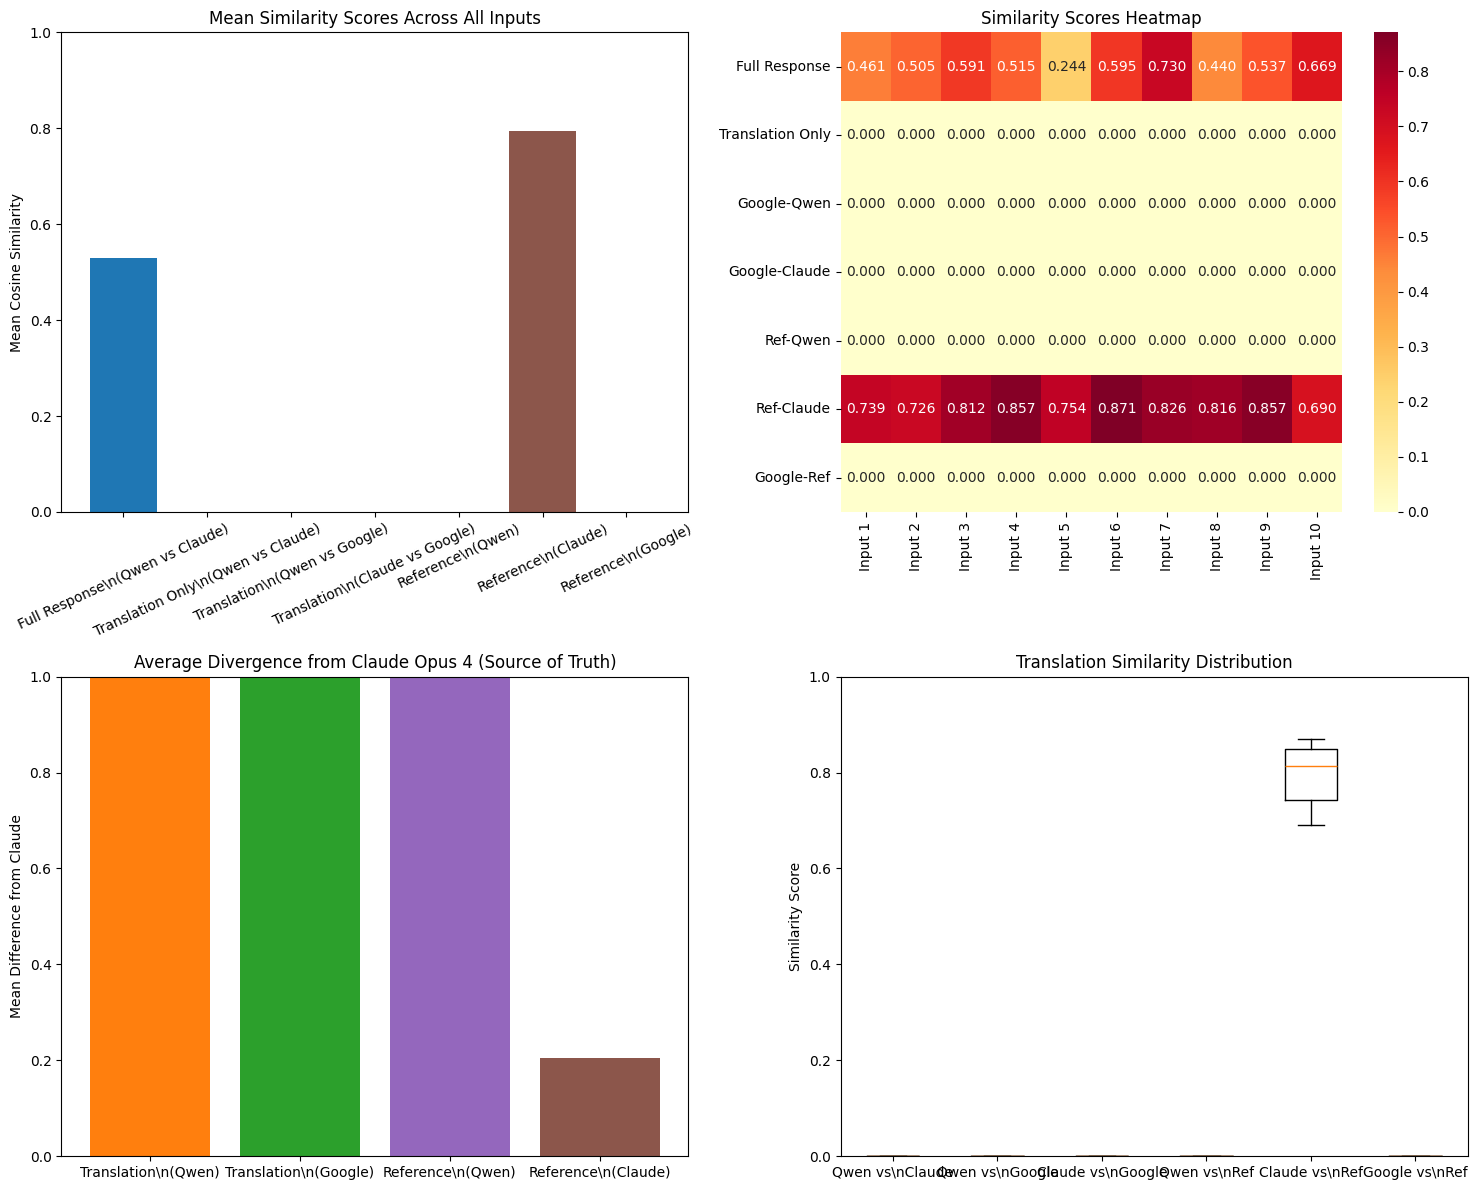

\n============================================================
SUMMARY STATISTICS
\nMean Full Response Similarity (Qwen vs Claude): 0.5288
Mean Translation Similarity (Qwen vs Claude): 0.0000
Mean Translation Similarity (Qwen vs Google): 0.0000
Mean Translation Similarity (Claude vs Google): 0.0000
Mean Reference Similarity (Qwen vs Ref): 0.0000
Mean Reference Similarity (Claude vs Ref): 0.7947
Mean Reference Similarity (Google vs Ref): 0.0000
\nQwen divergence from Claude (mean): 1.0000
Google divergence from Claude (mean): 1.0000
Qwen divergence from Reference (mean): 1.0000
Claude divergence from Reference (mean): 0.2053
Google divergence from Reference (mean): 1.0000
\n============================================================
DETAILED RESULTS
                                                  input_text                                                                                                                                                                                    

In [5]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import anthropic
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
from scipy.stats import pearsonr
import requests
from googletrans import Translator
from datasets import load_dataset
import random
import time
from dotenv import load_dotenv
import os

# Configuration
SYSTEM_PROMPT = '''You are an expert translator, you will receive text in a JSON format that must be translated and explained. Identify the most challanging structures in the given sentence and respond with an explaination and a whole text translation. The input JSON format is the following '{"input_text":"<text_here>"}'. The output JSON format is the following '{"translated_text":"<translated_text", "explainations_list": [...]}". Respond with only the valid JSON and only the valid JSON, do not output any other strings.'''

# API Keys (replace with your actual keys)
ANTHROPIC_API_KEY = "your_anthropic_api_key_here"

# Load environment variables

load_dotenv()

# Get API keys from environment
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

# Validate API keys
if not ANTHROPIC_API_KEY:
    raise ValueError("ANTHROPIC_API_KEY not found in .env file")

# Load dataset from Hugging Face Datasets (wmt/wmt19 zh-en)
# NOTE: this will download the dataset the first time if not present. SAMPLE_SIZE is read from .env with a safe fallback.
SAMPLE_SIZE_ENV = os.getenv("SAMPLE_SIZE")
try:
    SAMPLE_SIZE = int(SAMPLE_SIZE_ENV) if SAMPLE_SIZE_ENV is not None else 10
except ValueError:
    print(f"Invalid SAMPLE_SIZE in .env ('{SAMPLE_SIZE_ENV}'), falling back to 10")
    SAMPLE_SIZE = 10
if SAMPLE_SIZE <= 0:
    raise ValueError("SAMPLE_SIZE must be a positive integer")
print(f"Loading WMT19 zh-en dataset from Hugging Face (sample size={SAMPLE_SIZE})...")

# Use the Hugging Face dataset id and config for Chinese-English
# NOTE: WMT19 uses 'validation' split, not 'test'
try:
    ds = load_dataset('wmt/wmt19', 'zh-en', split='validation')
    print(f"Successfully loaded WMT19 dataset with {len(ds)} examples")
except Exception as e:
    raise RuntimeError(f"Failed to load wmt/wmt19 zh-en from Hugging Face datasets: {e}")

# Optionally shuffle deterministically then select the requested number of examples
try:
    ds = ds.shuffle(seed=42)
    subset = ds.select(range(min(SAMPLE_SIZE, len(ds))))
except Exception:
    # If shuffle/select not available for this dataset object, fall back to list slicing
    ds_list = list(ds)
    subset = ds_list[:SAMPLE_SIZE]

# Load Qwen3-8B model
print("Loading Qwen3-8B model...")
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B", trust_remote_code=True)
qwen_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-8B",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)

# Initialize Claude client
claude_client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

# Initialize sentence transformer for semantic similarity
print("Loading sentence transformer for similarity comparison...")
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

# Google Translate function (using googletrans)
def google_translate(text, from_lang='zh', to_lang='en'):
    """Translate text using googletrans Translator (no API key required).
    Note: install with `pip install googletrans==4.0.0-rc1` if not already installed.
    """
    try:
        # googletrans uses language codes like 'zh-cn' for simplified Chinese
        dest = to_lang
        src = from_lang
        if from_lang == 'zh':
            src = 'zh-cn'
        if to_lang == 'zh':
            dest = 'zh-cn'
        translator = Translator()
        translated = translator.translate(text, src=src, dest=dest)
        return translated.text
    except Exception as e:
        print(f"Google translate error: {e}")
        return None

# Function to prompt Qwen3-8B
def prompt_qwen(text):
    input_json = json.dumps({"input_text": text})
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": input_json}
    ]

    text_input = qwen_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = qwen_tokenizer([text_input], return_tensors="pt").to(qwen_model.device)

    with torch.no_grad():
        outputs = qwen_model.generate(**inputs, max_new_tokens=512, temperature=0.7)

    response = qwen_tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response

# Function to prompt Claude Opus 4
def prompt_claude(text):
    input_json = json.dumps({"input_text": text})

    message = claude_client.messages.create(
        model="claude-opus-4-20250514",
        max_tokens=1024,
        system=SYSTEM_PROMPT,
        messages=[
            {"role": "user", "content": input_json}
        ]
    )

    return message.content[0].text

# Process dataset
results = []

# Iterate over selected subset. Each example has a 'translation' dict with 'zh' and 'en' keys.
for idx, example in enumerate(subset):
    try:
        translation = example['translation']
        # The HF dataset returns plain Python strings for translations
        text = translation.get('zh') if isinstance(translation, dict) else ''
        reference_translation = translation.get('en') if isinstance(translation, dict) else ''
    except Exception:
        # If subset is a plain list (fallback path), treat example as dict-like
        try:
            translation = example['translation']
            text = translation['zh']
            reference_translation = translation['en']
        except Exception:
            text = ''
            reference_translation = ''

    print(f"\nProcessing [{idx+1}/{SAMPLE_SIZE}]: {text[:60]}...")

    # Get Qwen response
    qwen_response = prompt_qwen(text)
    print(f"Qwen response: {qwen_response[:100]}...")

    # Get Claude response
    claude_response = prompt_claude(text)
    print(f"Claude response: {claude_response[:100]}...")

    # Parse JSON responses
    try:
        qwen_json = json.loads(qwen_response)
        qwen_translation = qwen_json.get('translated_text', '')
    except:
        qwen_translation = ''

    try:
        claude_json = json.loads(claude_response)
        claude_translation = claude_json.get('translated_text', '')
    except:
        claude_translation = ''

    # Get Google translation (zh->en to match the direction of the reference)
    google_translation = google_translate(text, from_lang='zh', to_lang='en')
    time.sleep(1)  # Rate limiting

    # Calculate semantic similarity between full responses
    embeddings = similarity_model.encode([qwen_response, claude_response])
    cosine_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

    # Translation similarity (Qwen vs Claude)
    trans_sim = 0
    if qwen_translation and claude_translation:
        trans_embeddings = similarity_model.encode([qwen_translation, claude_translation])
        trans_sim = cosine_similarity([trans_embeddings[0]], [trans_embeddings[1]])[0][0]

    # Google vs Qwen translation similarity
    google_qwen_sim = 0
    if google_translation and qwen_translation:
        google_qwen_embeddings = similarity_model.encode([google_translation, qwen_translation])
        google_qwen_sim = cosine_similarity([google_qwen_embeddings[0]], [google_qwen_embeddings[1]])[0][0]

    # Google vs Claude translation similarity
    google_claude_sim = 0
    if google_translation and claude_translation:
        google_claude_embeddings = similarity_model.encode([google_translation, claude_translation])
        google_claude_sim = cosine_similarity([google_claude_embeddings[0]], [google_claude_embeddings[1]])[0][0]

    # Reference vs Qwen/Claude similarity
    ref_qwen_sim = 0
    ref_claude_sim = 0
    google_ref_sim = 0
    if reference_translation:
        if qwen_translation:
            ref_qwen_embeddings = similarity_model.encode([qwen_translation, reference_translation])
            ref_qwen_sim = cosine_similarity([ref_qwen_embeddings[0]], [ref_qwen_embeddings[1]])[0][0]
        if claude_translation:
            ref_claude_embeddings = similarity_model.encode([claude_translation, reference_translation])
            ref_claude_sim = cosine_similarity([ref_claude_embeddings[0]], [ref_claude_embeddings[1]])[0][0]
        if google_translation:
            google_ref_embeddings = similarity_model.encode([google_translation, reference_translation])
            google_ref_sim = cosine_similarity([google_ref_embeddings[0]], [google_ref_embeddings[1]])[0][0]

    results.append({
        'input_text': text,
        'reference_translation': reference_translation,
        'qwen_response': qwen_response,
        'claude_response': claude_response,
        'qwen_translation': qwen_translation,
        'claude_translation': claude_translation,
        'google_translation': google_translation,
        'full_response_similarity': cosine_sim,
        'translation_similarity': trans_sim,
        'google_qwen_similarity': google_qwen_sim,
        'google_claude_similarity': google_claude_sim,
        'ref_qwen_similarity': ref_qwen_sim,
        'ref_claude_similarity': ref_claude_sim,
        'google_ref_similarity': google_ref_sim
    })

# Create results dataframe
results_df = pd.DataFrame(results)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mean similarity scores
similarity_means = {
    'Full Response\\n(Qwen vs Claude)': results_df['full_response_similarity'].mean(),
    'Translation Only\\n(Qwen vs Claude)': results_df['translation_similarity'].mean(),
    'Translation\\n(Qwen vs Google)': results_df['google_qwen_similarity'].mean(),
    'Translation\\n(Claude vs Google)': results_df['google_claude_similarity'].mean(),
    'Reference\\n(Qwen)': results_df['ref_qwen_similarity'].mean(),
    'Reference\\n(Claude)': results_df['ref_claude_similarity'].mean(),
    'Reference\\n(Google)': results_df['google_ref_similarity'].mean()
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
axes[0, 0].bar(similarity_means.keys(), similarity_means.values(), color=colors[:len(similarity_means)])
axes[0, 0].set_ylabel('Mean Cosine Similarity')
axes[0, 0].set_title('Mean Similarity Scores Across All Inputs')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=25)

# 2. Per-input similarity heatmap (expanded)
similarity_matrix = results_df[[
    'full_response_similarity', 'translation_similarity', 'google_qwen_similarity',
    'google_claude_similarity', 'ref_qwen_similarity', 'ref_claude_similarity', 'google_ref_similarity'
]].T
sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0, 1],
            xticklabels=[f"Input {i+1}" for i in range(len(results_df))],
            yticklabels=['Full Response', 'Translation Only', 'Google-Qwen', 'Google-Claude', 'Ref-Qwen', 'Ref-Claude', 'Google-Ref'])
axes[0, 1].set_title('Similarity Scores Heatmap')

# 3. Difference from Claude (source of truth)
difference_data = {
    'Translation\\n(Qwen)': 1 - results_df['translation_similarity'].mean(),
    'Translation\\n(Google)': 1 - results_df['google_claude_similarity'].mean(),
    'Reference\\n(Qwen)': 1 - results_df['ref_qwen_similarity'].mean(),
    'Reference\\n(Claude)': 1 - results_df['ref_claude_similarity'].mean()
}

axes[1, 0].bar(difference_data.keys(), difference_data.values(), color=['#ff7f0e', '#2ca02c', '#9467bd', '#8c564b'])
axes[1, 0].set_ylabel('Mean Difference from Claude')
axes[1, 0].set_title('Average Divergence from Claude Opus 4 (Source of Truth)')
axes[1, 0].set_ylim([0, 1])

# 4. Box plot of similarities
box_data = [
    results_df['translation_similarity'],
    results_df['google_qwen_similarity'],
    results_df['google_claude_similarity'],
    results_df['ref_qwen_similarity'],
    results_df['ref_claude_similarity'],
    results_df['google_ref_similarity']
]

axes[1, 1].boxplot(box_data, labels=['Qwen vs\\nClaude', 'Qwen vs\\nGoogle', 'Claude vs\\nGoogle', 'Qwen vs\\nRef', 'Claude vs\\nRef', 'Google vs\\nRef'])
axes[1, 1].set_ylabel('Similarity Score')
axes[1, 1].set_title('Translation Similarity Distribution')
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('model_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\\nMean Full Response Similarity (Qwen vs Claude): {results_df['full_response_similarity'].mean():.4f}")
print(f"Mean Translation Similarity (Qwen vs Claude): {results_df['translation_similarity'].mean():.4f}")
print(f"Mean Translation Similarity (Qwen vs Google): {results_df['google_qwen_similarity'].mean():.4f}")
print(f"Mean Translation Similarity (Claude vs Google): {results_df['google_claude_similarity'].mean():.4f}")
print(f"Mean Reference Similarity (Qwen vs Ref): {results_df['ref_qwen_similarity'].mean():.4f}")
print(f"Mean Reference Similarity (Claude vs Ref): {results_df['ref_claude_similarity'].mean():.4f}")
print(f"Mean Reference Similarity (Google vs Ref): {results_df['google_ref_similarity'].mean():.4f}")

print(f"\\nQwen divergence from Claude (mean): {(1 - results_df['translation_similarity'].mean()):.4f}")
print(f"Google divergence from Claude (mean): {(1 - results_df['google_claude_similarity'].mean()):.4f}")
print(f"Qwen divergence from Reference (mean): {(1 - results_df['ref_qwen_similarity'].mean()):.4f}")
print(f"Claude divergence from Reference (mean): {(1 - results_df['ref_claude_similarity'].mean()):.4f}")
print(f"Google divergence from Reference (mean): {(1 - results_df['google_ref_similarity'].mean()):.4f}")

# Display detailed results
print("\\n" + "="*60)
print("DETAILED RESULTS")
print("="*60)
print(results_df.to_string())